In [331]:
#https://www.youtube.com/watch?v=QIUxPv5PJOY&t=2317s&ab_channel=ComputerScience
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN

import matplotlib.pyplot as plt
import matplotlib.dates
plt.style.use('fivethirtyeight')

import seaborn as sns

In [153]:
#Ucitavanja csv-a i stavljanje da je date kolona index kolona
df = pd.read_csv("TSLA.csv");

#Provera da li ijedna kolona ima null vrednosti
#df.isnull().sum()
#df = df.dropna()

#Konvertovanje podataka kolone Date u Date format
df['Date'] = pd.to_datetime(df.Date)
df

# High = maximalno cena u datom periodu odnosno u danu
# Low = minimalna cena u datom periodu odnosno u danu
# Open = na kojoj ceni je stock poceo na pocetku dana
# Close = na kojoj ceni je stock zavrsion na kraju dana
# Volumen = kolicina koliko je prosla kroz berzu
# Adj Close = podesena cena nakon uracunavanja bilo kakvih korporativnih akcija ( velika kupovina ili tako nesto)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-07-05,6.162000,6.334000,6.160000,6.246000,6.246000,6269000
1,2012-07-06,6.198000,6.346000,6.160000,6.198000,6.198000,3922500
2,2012-07-09,6.188000,6.366000,6.134000,6.298000,6.298000,4552500
3,2012-07-10,6.308000,6.496000,6.178000,6.254000,6.254000,3792000
4,2012-07-11,6.314000,6.336000,6.202000,6.302000,6.302000,3193000
...,...,...,...,...,...,...,...
2510,2022-06-27,748.099976,756.210022,727.700012,734.760010,734.760010,29726100
2511,2022-06-28,733.450012,749.909973,697.030029,697.989990,697.989990,30130400
2512,2022-06-29,691.500000,693.520020,666.820007,685.469971,685.469971,27632400
2513,2022-06-30,673.530029,688.369995,656.590027,673.419983,673.419983,31533500


In [154]:
# df = pd.read_csv("TSLA.csv");

# df['Date'] = pd.to_datetime(df.Date)

# #greater than the start date and smaller than the end date
# mask = (df['Date'] > '2020-07-05')
# test_data = df.loc[mask]
# len(test_data)

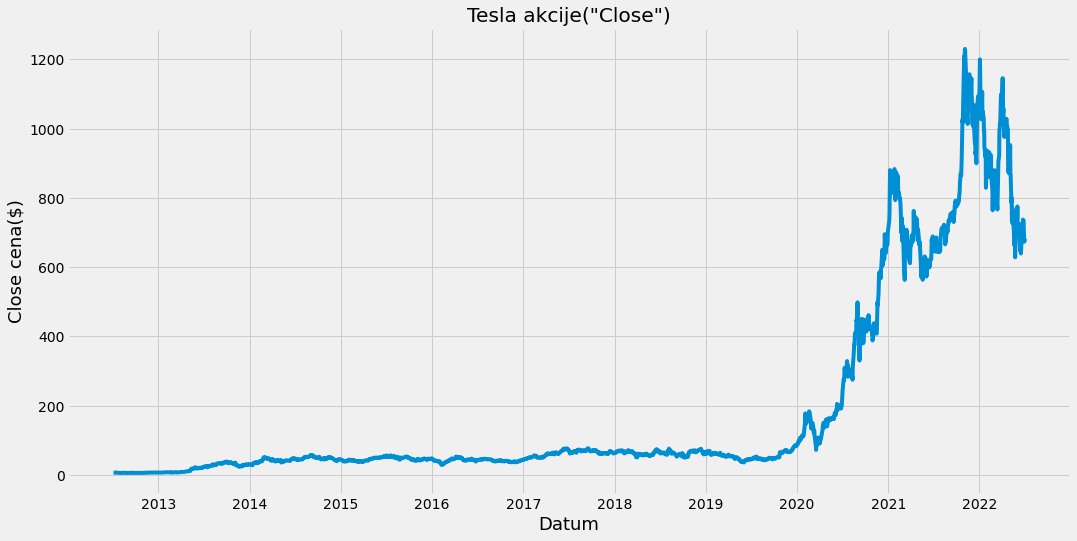

In [155]:
import matplotlib.dates as mdates
#Vizualizacija Close cene akcija

plt.figure(figsize=(16,8))
ax = plt.gca()

#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)   

plt.plot(df['Date'], df['Close'])
plt.show()

In [156]:
def scale_data(dataset, scaler):
    #Skaliranje podataka
#     scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def inverse_scale(dataset, scaler):
    #Inverse skaliranje
#     scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.inverse_transform(dataset)

def train_test_split(dataset, split=0.8):
    
    #Broj podataka koji ce biti iskorisceni za treniranje
    training_data_len = math.ceil( len(dataset) * split )
    
    print("Ukupan broj podataka: " + str(len(dataset)))
    print("Train broj podataka: " + str(training_data_len))
    print("Test broj podataka: " + str(len(dataset) - training_data_len))
    
    #Kreira training set podataka
    train_data = dataset[0:training_data_len , :]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i,0])
    #     if i<= 61:
    #         print(x_train)
    #         print(y_train)
    #         print()


    #Konvertuje podatke u nparray
    x_train, y_train = np.array(x_train), np.array(y_train)
    print(x_train.shape)
    #Reshape podataka
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape


    #Kreira test set podataka
    test_data = dataset[training_data_len - 60 : , :]

    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])


    #Konvertuje podatke u nparray
    x_test = np.array(x_test)
    #Reshape podataka
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [157]:
#MAIN METODA

#Ucitavanje podatak i konverzija Date kolone u datetime tip
df = pd.read_csv("TSLA.csv");
df['Date'] = pd.to_datetime(df.Date)

#Kreira novi dataframe samo sa 'Close' kolonom
data = df.filter(['Close'])

#Konvertira podateke u nparray
dataset = data.values

#Scaler inicijalizacija
scaler = MinMaxScaler(feature_range=(0,1))

#Skaliraj podatke kolone 'Close'
scaled_data, scaler = scale_data(dataset, scaler)

#Train, test split podataka
x_train, y_train, x_test, y_test, training_data_len= train_test_split(scaled_data, split=0.8)

Ukupan broj podataka: 2515
Train broj podataka: 2012
Test broj podataka: 503
(1952, 60)


In [342]:
#Postavljanje LSTM modela

#Model 1
model1 = Sequential()
model1.add(LSTM(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(55, return_sequences = False))
model1.add(Dropout(0.2))
#Dodaje dense layere sa 25 i 1 neuronom
model1.add(Dense(25))
model1.add(Dense(1))


#Kompilacija modela
model1.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model1.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble(.hdf5 - ekstenzija da celu mrezu sacuva u jedan fajl)
model1.save('saved_models/model1.hdf5')


#Predvidja cenu na osnovu test skupa
predictions1 = model1.predict(x_test)
predictions1 = inverse_scale(predictions1, scaler)
# predictions = scaler.inverse_transform(predictions)

#Get rmse
rmse = np.sqrt( np.mean(predictions1 - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 6s 49ms/step - loss: 2.0302e-04
Epoch 2/10
61/61 [==============================] - 3s 49ms/step - loss: 4.6146e-05
Epoch 3/10
61/61 [==============================] - 3s 50ms/step - loss: 3.5916e-05
Epoch 4/10
61/61 [==============================] - 3s 49ms/step - loss: 2.9287e-05
Epoch 5/10
61/61 [==============================] - 3s 49ms/step - loss: 3.2386e-05
Epoch 6/10
61/61 [==============================] - 3s 54ms/step - loss: 3.2615e-05
Epoch 7/10
61/61 [==============================] - 3s 52ms/step - loss: 2.4012e-05
Epoch 8/10
61/61 [==============================] - 3s 53ms/step - loss: 2.7224e-05
Epoch 9/10
61/61 [==============================] - 3s 52ms/step - loss: 2.1401e-05
Epoch 10/10
16/16 [==============================] - 1s 28ms/step


702.4407746051016

In [345]:
#Model 2
model2 = Sequential()
model2.add(GRU(65, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(GRU(55, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(GRU(25))
model2.add(Dense(1))

#Kompilacija modela
model2.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model2.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model2.save('saved_models/model2.hdf5')


#Predvidja cenu na osnovu test skupa
predictions2 = model2.predict(x_test)
predictions2 = inverse_scale(predictions2, scaler)

#Get rmse
rmse = np.sqrt( np.mean(predictions2 - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 9s 66ms/step - loss: 2.8637e-04
Epoch 2/10
61/61 [==============================] - 4s 66ms/step - loss: 2.2894e-05
Epoch 3/10
61/61 [==============================] - 4s 67ms/step - loss: 1.8994e-05
Epoch 4/10
61/61 [==============================] - 4s 66ms/step - loss: 2.0823e-05
Epoch 5/10
61/61 [==============================] - 4s 66ms/step - loss: 2.1001e-05
Epoch 6/10
61/61 [==============================] - 4s 67ms/step - loss: 1.9121e-05
Epoch 7/10
61/61 [==============================] - 4s 67ms/step - loss: 2.0053e-05
Epoch 8/10
61/61 [==============================] - 4s 66ms/step - loss: 2.0664e-05
Epoch 9/10
61/61 [==============================] - 4s 66ms/step - loss: 1.6676e-05
Epoch 10/10
16/16 [==============================] - 1s 26ms/step


702.8708282553681

In [381]:
#Model 3
model3 = Sequential()
model3.add(SimpleRNN(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(40))
model3.add(Dropout(0.2))
model3.add(Dense(10))
model3.add(Dense(1))


#Kompilacija modela
model3.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model3.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model3.save('saved_models/model3.hdf5')


#Predvidja cenu na osnovu test skupa
predictions3 = model3.predict(x_test)
predictions3 = inverse_scale(predictions3, scaler)
# predictions = scaler.inverse_transform(predictions)

#Get rmse
rmse = np.sqrt( np.mean(predictions3 - y_test) **2)
rmse

Epoch 1/10
61/61 [==============================] - 3s 21ms/step - loss: 0.0116
Epoch 2/10
61/61 [==============================] - 1s 21ms/step - loss: 0.0011
Epoch 3/10
61/61 [==============================] - 1s 21ms/step - loss: 6.7871e-04
Epoch 4/10
61/61 [==============================] - 1s 21ms/step - loss: 5.4718e-04
Epoch 5/10
61/61 [==============================] - 1s 21ms/step - loss: 4.2379e-04
Epoch 6/10
61/61 [==============================] - 1s 21ms/step - loss: 3.3249e-04
Epoch 7/10
61/61 [==============================] - 1s 21ms/step - loss: 2.9475e-04
Epoch 8/10
61/61 [==============================] - 1s 22ms/step - loss: 2.4797e-04
Epoch 9/10
61/61 [==============================] - 1s 21ms/step - loss: 2.0486e-04
Epoch 10/10
16/16 [==============================] - 0s 9ms/step


682.4552075690854

In [383]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

# model1 = load_model('saved_models/model1.hdf5')
# model2 = load_model('saved_models/model2.hdf5')
# model3 = load_model('saved_models/model3.hdf5')

prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

prediction1 = inverse_scale(prediction1, scaler)
prediction2 = inverse_scale(prediction2, scaler)
prediction3 = inverse_scale(prediction3, scaler)


accuracy1 = np.sqrt( np.mean(prediction1 - y_test) **2)
accuracy2 = np.sqrt( np.mean(prediction2 - y_test) **2)
accuracy3 = np.sqrt( np.mean(prediction3 - y_test) **2)



#RUNCO DOBIJANJE MEANA SA WEIGHTS
#################################################
# models = [model1, model2, model3]
# preds = [model.predict(x_test) for model in models]
# preds=np.array(preds)

# for idx, x in enumerate(preds):
#     preds[idx] = inverse_scale(preds[idx], scaler)
    
# weights = [0.8, 0.3, 0.2]

# #Sabira resenja sve tri liste i pomnozi ih sa weightsom
# weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))

# weight_sum = 0;
# for i in weights:
#     weight_sum += i
    
# #Podeli sa brojem modela svaku kolonu da se dobije mean
# weighted_preds = [element/weight_sum for element in weighted_preds] #len(models)
#################################################

#weighted_accuracy = np.sqrt( np.mean(weighted_preds - y_test) **2)


#Pregled preciznosti modela 1,2,3
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)

16/16 [==============================] - 0s 8ms/step
Accuracy Score for model1 =  702.4407746051016
Accuracy Score for model2 =  702.8708282553681
Accuracy Score for model3 =  682.4552075690854


In [384]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

# model1 = load_model('saved_models/model1.hdf5')
# model2 = load_model('saved_models/model2.hdf5')
# model3 = load_model('saved_models/model3.hdf5')
# models = [model1, model2, model3]

def make_model1():
    #Model 1
    model1 = Sequential()
    model1.add(LSTM(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model1.add(Dropout(0.2))
    model1.add(LSTM(55, return_sequences = False))
    model1.add(Dropout(0.2))
    #Dodaje dense layere sa 25 i 1 neuronom
    model1.add(Dense(25))
    model1.add(Dense(1))


    #Kompilacija modela
    model1.compile(optimizer='adam', loss='mean_squared_error')
    
    return model1

def make_model2():
    #Model 2
    model2 = Sequential()
    model2.add(GRU(65, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model2.add(Dropout(0.2))
    model2.add(GRU(55, return_sequences = True))
    model2.add(Dropout(0.2))
    model2.add(GRU(25))
    model2.add(Dense(1))

    #Kompilacija modela
    model2.compile(optimizer='adam', loss='mean_squared_error')
    return model2

    
def make_model3():
    #Model 3
    model3 = Sequential()
    model3.add(SimpleRNN(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model3.add(Dropout(0.2))
    model3.add(SimpleRNN(40))
    model3.add(Dropout(0.2))
    model3.add(Dense(10))
    model3.add(Dense(1))


    #Kompilacija modela
    model3.compile(optimizer='adam', loss='mean_squared_error')
    return model3


from scikeras.wrappers import KerasRegressor
estimator1 = KerasRegressor(model=make_model1, epochs=10, batch_size=32)
estimator2 = KerasRegressor(model=make_model2, epochs=10, batch_size=32)
estimator3 = KerasRegressor(model=make_model3, epochs=10, batch_size=32)


level0 = list()
level0.append(('model1', estimator1))
level0.append(('model2', estimator2))
level0.append(('model3', estimator3))

ensemble = VotingRegressor(estimators=level0)
ensemble.fit(x_train, y_train)

Epoch 1/10
61/61 [==============================] - 8s 62ms/step - loss: 1.4530e-04
Epoch 2/10
61/61 [==============================] - 4s 62ms/step - loss: 2.8749e-05
Epoch 3/10
61/61 [==============================] - 4s 62ms/step - loss: 2.0999e-05
Epoch 4/10
61/61 [==============================] - 4s 62ms/step - loss: 1.9909e-05
Epoch 5/10
61/61 [==============================] - 4s 61ms/step - loss: 1.7950e-05
Epoch 6/10
61/61 [==============================] - 4s 62ms/step - loss: 2.0823e-05
Epoch 7/10
61/61 [==============================] - 4s 62ms/step - loss: 1.8010e-05
Epoch 8/10
61/61 [==============================] - 4s 62ms/step - loss: 1.6215e-05
Epoch 9/10
61/61 [==============================] - 4s 62ms/step - loss: 1.8197e-05
Epoch 10/10
61/61 [==============================] - 4s 62ms/step - loss: 1.8776e-05
Epoch 1/10
61/61 [==============================] - 3s 20ms/step - loss: 0.0150
Epoch 2/10
61/61 [==============================] - 1s 20ms/step - loss: 0.0014

VotingRegressor(estimators=[('model1',
                             KerasRegressor(batch_size=32, epochs=10, model=<function make_model1 at 0x000002669AF7ED40>, verbose=0)),
                            ('model2',
                             KerasRegressor(batch_size=32, epochs=10, model=<function make_model2 at 0x000002669AF7F400>)),
                            ('model3',
                             KerasRegressor(batch_size=32, epochs=10, model=<function make_model3 at 0x000002669AF7F910>))])

In [386]:
final_predictions = ensemble.predict(x_test)

final_predictions = final_predictions.reshape((len(final_predictions),1))
#preds1=np.array(preds1)

# for idx, x in enumerate(predictions1):

final_predictions = inverse_scale(final_predictions, scaler)
    
    
score = np.sqrt( np.mean(final_predictions - y_test) **2)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for weighted average ensemble = ', score)

16/16 [==============================] - 0s 8ms/step
Accuracy Score for model1 =  702.4407746051016
Accuracy Score for model2 =  702.8708282553681
Accuracy Score for model3 =  682.4552075690854
Accuracy Score for weighted average ensemble =  694.870764277662


In [289]:
predictions1[0]

array([0.18520172], dtype=float32)

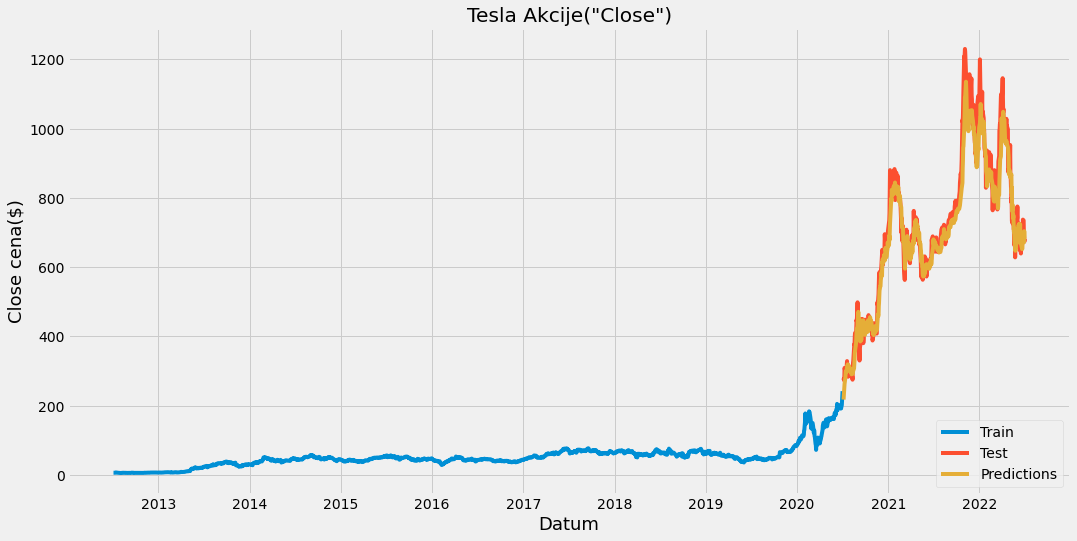

In [387]:
#Plot the results
train = data[:training_data_len]
data_date = df.filter(['Date'])
train['Datum'] = data_date[:training_data_len]

valid = data[training_data_len:]
valid['Predictions'] = final_predictions
valid['Datum'] = data_date[training_data_len:]
# train['Datum'] = df['Date']

#Visualize the data
plt.figure(figsize=(16,8))
ax = plt.gca()
#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla Akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)

plt.plot(train['Datum'], train['Close'])
plt.plot(valid['Datum'], valid[['Close', 'Predictions']])

plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#DERN: Deep Ensemble Learning Model for Short- and Long-Term Prediction of Baltic Dry Index
# https://www.researchgate.net/publication/339456466_DERN_Deep_Ensemble_Learning_Model_for_Short-_and_Long-Term_Prediction_of_Baltic_Dry_Index

#Youtube tutorial ensamble deep learning
#https://www.youtube.com/watch?v=-ix_Mjzu8BU&ab_channel=DigitalSreeni

#Bagging, Boosting, Stacking modeli ensambla objasnjeni
#https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205




#Stacking za regresije USEFUl
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/



#GRU MODEL ZA MREZU POGLEDAJ